<a href="https://colab.research.google.com/github/cydal/tsExtract/blob/master/EnergyConsumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### https://www.kaggle.com/robikscube/hourly-energy-consumption?select=NI_hourly.csv

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import scipy.stats


from helper import *
import xgboost

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df = pd.read_csv("DAYTON_hourly.csv")
df["Datetime"] = pd.to_datetime(df["Datetime"])
df = df.set_index("Datetime")

In [ ]:
df

,DAYTON_MW
Datetime,
2004-12-31 01:00:00,1596.0
2004-12-31 02:00:00,1517.0
2004-12-31 03:00:00,1486.0
2004-12-31 04:00:00,1469.0
2004-12-31 05:00:00,1472.0
...,...
2018-01-01 20:00:00,2732.0
2018-01-01 21:00:00,2724.0
2018-01-01 22:00:00,2664.0


In [ ]:
df["DAYTON_MW"].shift(1)

Datetime
2004-12-31 01:00:00       NaN
2004-12-31 02:00:00    1596.0
2004-12-31 03:00:00    1517.0
2004-12-31 04:00:00    1486.0
2004-12-31 05:00:00    1469.0
                        ...  
2018-01-01 20:00:00    2714.0
2018-01-01 21:00:00    2732.0
2018-01-01 22:00:00    2724.0
2018-01-01 23:00:00    2664.0
2018-01-02 00:00:00    2614.0
Name: DAYTON_MW, Length: 121275, dtype: float64

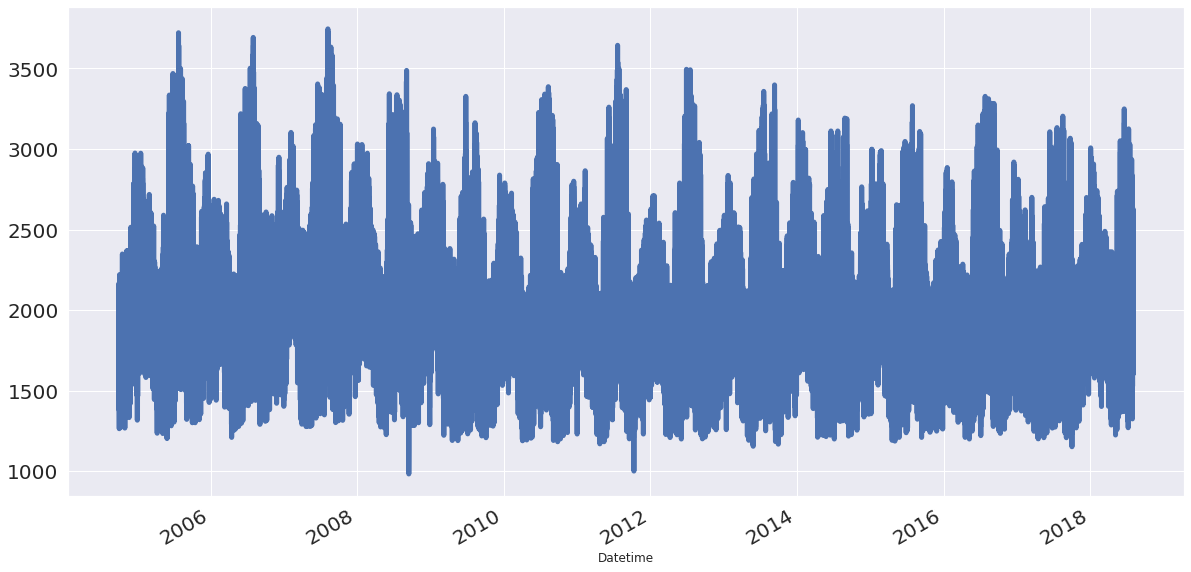

In [ ]:
df["DAYTON_MW"].plot(figsize=(20,10), linewidth=5, fontsize=20)

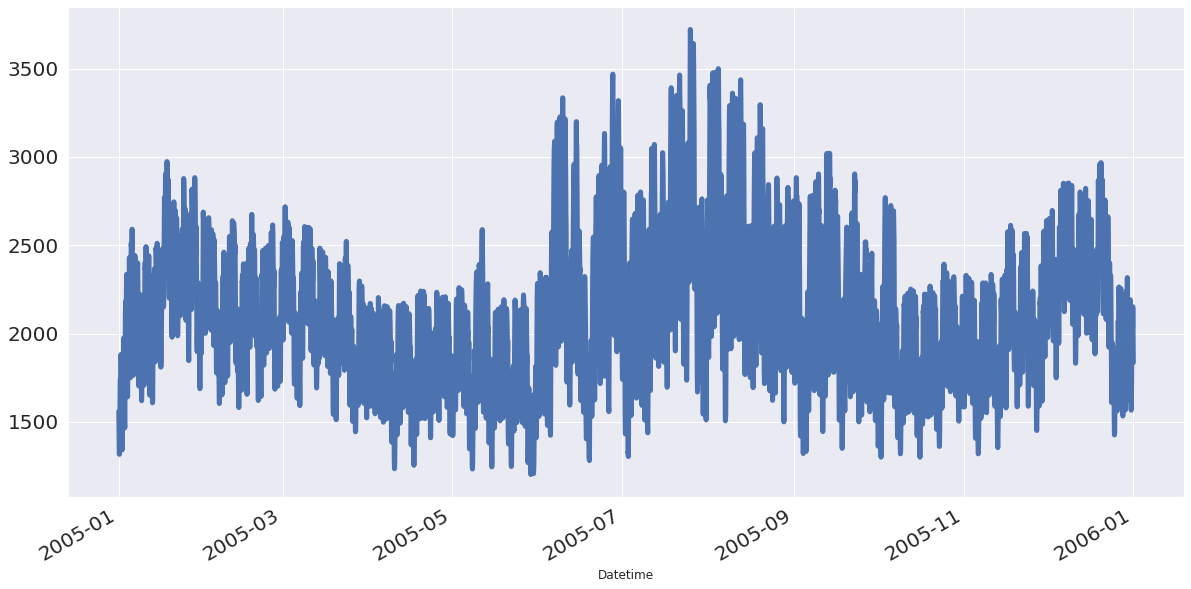

In [ ]:
df["DAYTON_MW"][df.index.year == 2005].plot(figsize=(20,10), linewidth=5, fontsize=20)

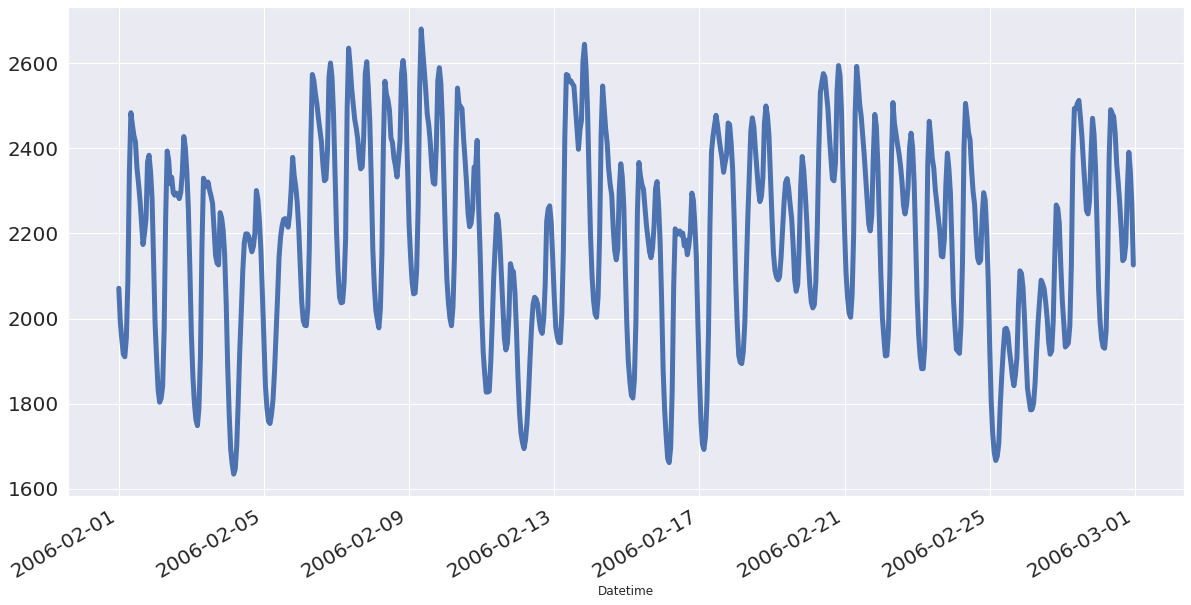

In [ ]:
df["DAYTON_MW"][((df.index.year == 2006) & (df.index.month == 2))].plot(figsize=(20,10), linewidth=5, fontsize=20)

In [ ]:
## We can see both seasonality and Trend.

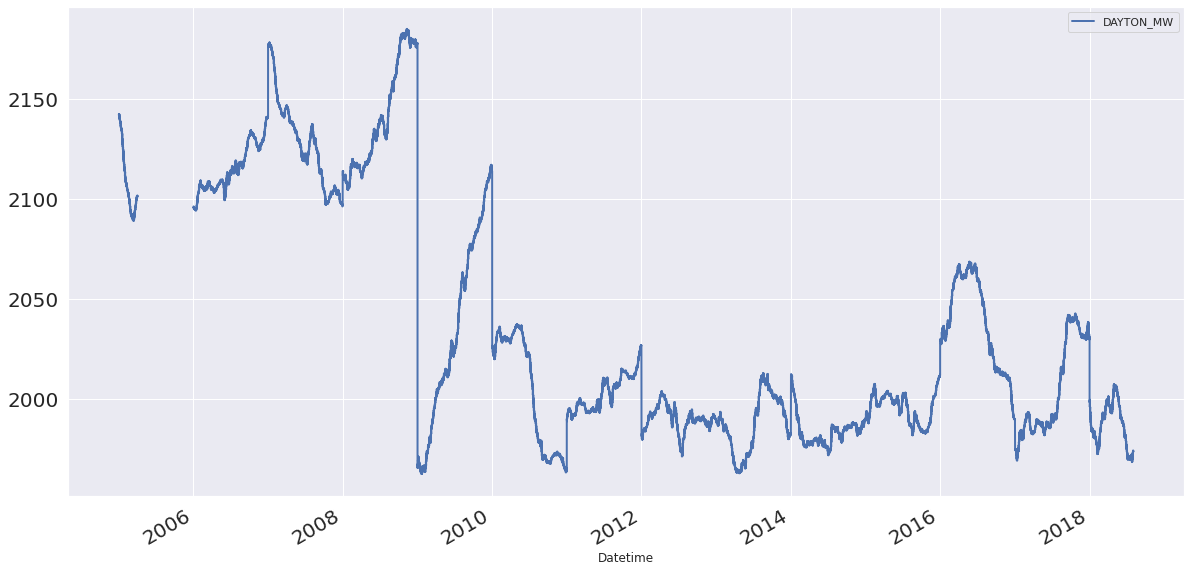

In [ ]:
df[["DAYTON_MW"]].rolling(8760).mean().plot(figsize=(20,10), linewidth=2, fontsize=20)

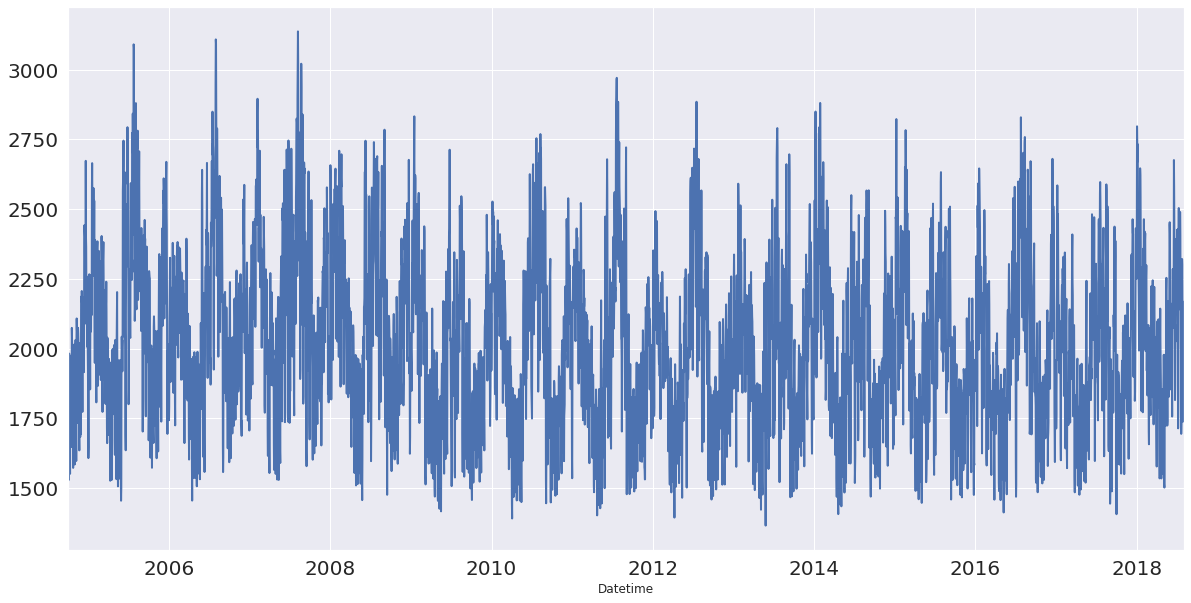

In [ ]:
df["DAYTON_MW"].resample('D').mean().plot(figsize=(20,10), linewidth=2, fontsize=20)

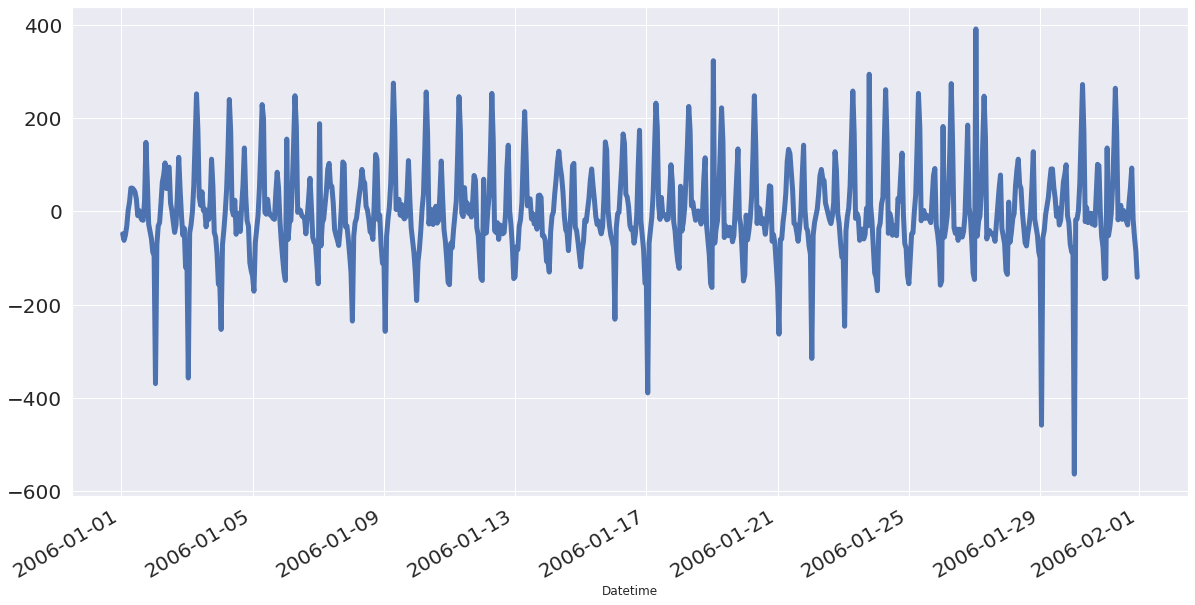

In [ ]:
df["DAYTON_MW"][((df.index.year == 2006) & (df.index.month == 1))].diff().plot(figsize=(20,10), linewidth=5, fontsize=20)

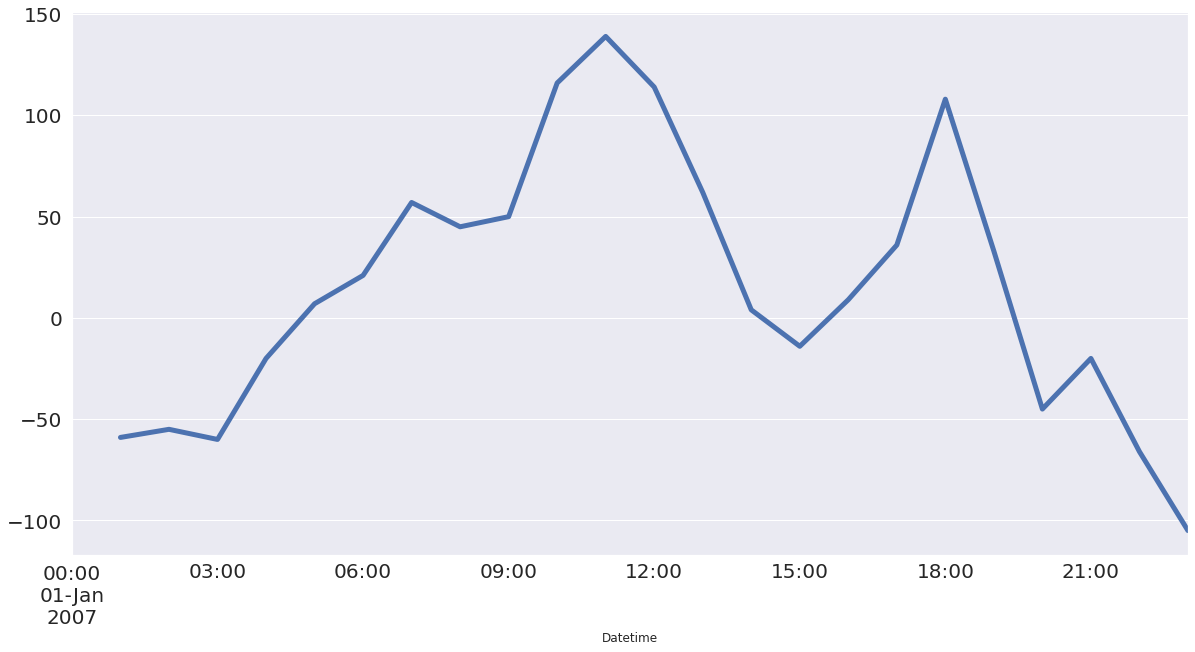

In [ ]:
df["DAYTON_MW"][((df.index.year == 2007) & 
                 (df.index.month == 1) & 
                 (df.index.day == 1))].diff().plot(figsize=(20,10), linewidth=5, fontsize=20)

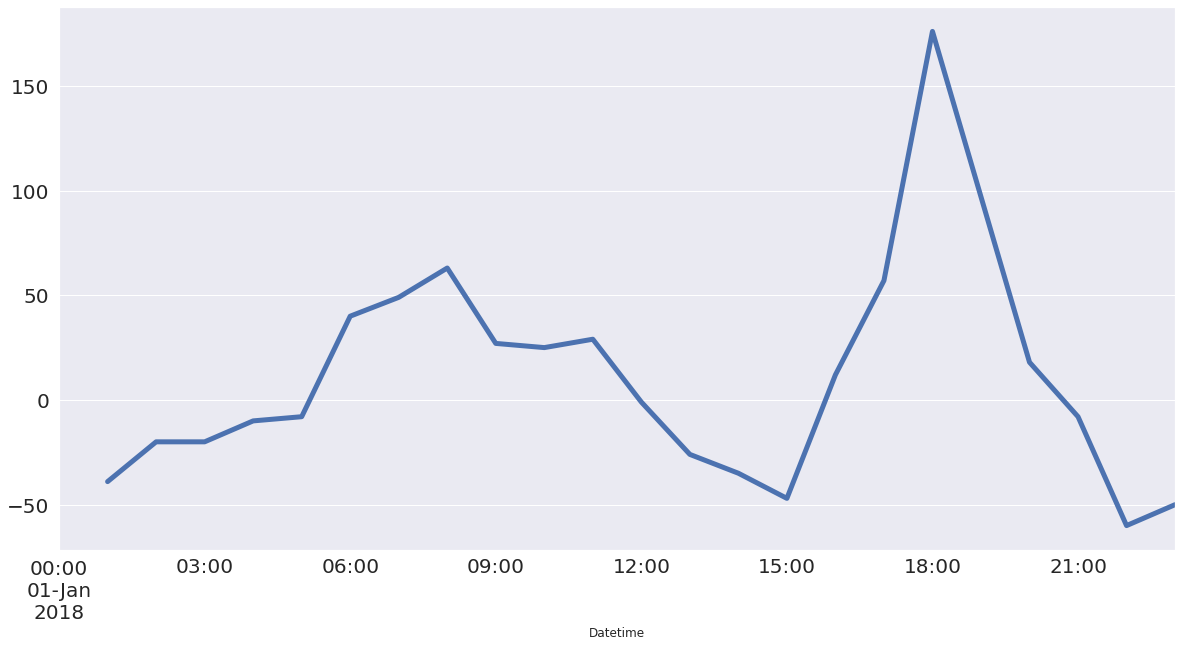

In [ ]:
df["DAYTON_MW"][((df.index.year == 2018) & 
                 (df.index.month == 1) & 
                 (df.index.day == 1))].diff().plot(figsize=(20,10), linewidth=5, fontsize=20)

In [4]:
index = df.index
win_24 = window_list(df["DAYTON_MW"], 24)

In [ ]:
df["DAYTON_MW"] #t+0 t+18 t+18 - 1+0

Datetime
2004-12-31 01:00:00    1596.0
2004-12-31 02:00:00    1517.0
2004-12-31 03:00:00    1486.0
2004-12-31 04:00:00    1469.0
2004-12-31 05:00:00    1472.0
                        ...  
2018-01-01 20:00:00    2732.0
2018-01-01 21:00:00    2724.0
2018-01-01 22:00:00    2664.0
2018-01-01 23:00:00    2614.0
2018-01-02 00:00:00    2552.0
Name: DAYTON_MW, Length: 121275, dtype: float64

In [ ]:
difference(df["DAYTON_MW"], 1)

Datetime
2004-12-31 01:00:00     NaN
2004-12-31 02:00:00   -79.0
2004-12-31 03:00:00   -31.0
2004-12-31 04:00:00   -17.0
2004-12-31 05:00:00     3.0
                       ... 
2018-01-01 20:00:00    18.0
2018-01-01 21:00:00    -8.0
2018-01-01 22:00:00   -60.0
2018-01-01 23:00:00   -50.0
2018-01-02 00:00:00   -62.0
Name: DAYTON_MW, Length: 121275, dtype: float64

In [5]:
win_24_mean = win_stat(win_24, "mean")
win_24_diff = difference_comb(df["DAYTON_MW"], 24, 10)
win_24_diff.shape 



##### 

(121275, 14)

In [7]:
combined_df = np.hstack((win_24, # Windowed Data -> 24
           win_24_mean, # Windowed Data MEAN -> 1
           win_24_diff, # Windowed Data DIFF  - 25 - 10 -> 14
           np.expand_dims(df["DAYTON_MW"], axis=1), # T+0 -> 1
           np.expand_dims(df["DAYTON_MW"].shift(-18), axis=1))) # T + 18 Target -> 1


combined_df.shape # 24 + 14 + 1 + 1 + 1 = 41

(121275, 41)

In [ ]:
## Difference Network - is not raw value
## Difference feature

In [35]:
## Target Lag - T+ for predictive variable

## todo - write error checks if values differ from what is expected
#  arguments
#  window - integer // window_statistics - list, 2 values (int & string)
#  difference / momentum / force - list, 2 values (int & int)


## when building features, minimum required argument is windows size
## Automate feature name passed in to feature variable
# will allow to handle errors all at once

## implement disjointed backwards lag e.g t-24 to t-48 // t-48 to t-96 e.t.c


def build_features(data, features_request, target_lag=3, include_tzero=True):

  ## Check window option present
  if "window" not in features_request.keys():
    raise Exception("Features dictionary must contain at least a window size")

  # Check input format correct
  if len(features_request["window"]) != 1:
    if type(features_request["window"][0]) != int:
      raise Exception("Expects list of size 1 with integer value for window size")

  def window(features_item):
    return(window_list(data, features_item[0]))

  def window_statistic(features_item):
    return(win_stat(window_list(data, features_item[0]), features_item[1]))

  def difference(features_item):
    return(difference_comb(data, features_item[0], features_item[1]))

  def momentum(features_item):
    return(momentum_comb(data, features_item[0], features_item[1]))

  def force(features_item):
    return(force_comb(data, features_item[0], features_item[1]))

  def difference_statistic(features_item):
    return(win_stat(difference_comb(data, features_item[0], features_item[1]), 
             features_item[2]))

  def momentum_statistic(features_item):
    return(win_stat(momentum_comb(data, features_item[0], features_item[1]), 
             features_item[2]))
    
  def force_statistic(features_item):
    return(win_stat(force_comb(data, features_item[0], features_item[1]), 
             features_item[2]))
    
  features_list = []
  features = {}

  stat_features = ["window_statistic", "difference_statistic", 
                   "momentum_statistic", "force_statistic"]

  nonstat_features = ["difference", "momentum", "force"]

  ## Save features to dictionary
  for key in features_request:
    features_list.append([key, locals()[key](features_request[key])])

  ## Get T+0 if Tplus0 is true
  if include_tzero:
    tzero = pd.DataFrame(np.expand_dims(data, axis=1), columns=["tzero"])

  # Get T+ target
  target = pd.DataFrame(np.expand_dims(data.shift(-target_lag), axis=1), 
                        columns=["Target_Tplus{0}".format(str(target_lag))])

  for f in features_list:
    if f[0] == "window":
      # Get window size for naming columns
      window_range = ["T-{0}".format(i) for i in range(1, features_request["window"][0]+1)][::-1]
      # Create DataFrame with window
      df = pd.DataFrame(f[1], columns=window_range)
    if f[0] in stat_features:
      feat_name = "_".join([str(x) for x in features_request[f[0]]])
      features[feat_name] = pd.DataFrame(f[1], columns=[feat_name])
    if f[0] in nonstat_features:
      feat_name = "_".join([str(x) for x in features_request[f[0]]])

      win_lag_diff = features_request[f[0]][0] - features_request[f[0]][1]
      print()
      window_range = ["{1}-{0}".format(i, feat_name) for i in range(1, win_lag_diff+1)][::-1]
      features[feat_name] = pd.DataFrame(f[1], columns=window_range)

  
  # Combine rest of features
  for d in features:
    df = pd.concat([df, features[d]], axis=1)

  # Add t+1 & t+0
  if include_tzero:
    df = pd.concat([df, tzero], axis=1)

  df = pd.concat([df, target], axis=1)

  return(df)

In [11]:
features_request = {
    "window":[24], 
    "window_statistic":[72, "median"], 
    "difference":[24, 10], #window_size and lag
    "difference_statistic":[24, 10, "mean"] # window_size, lag, statistic
}

In [41]:
features = build_features(df["DAYTON_MW"], features_request, target_lag=3, include_tzero=True)

In [ ]:
#from varname import nameof
#! pip install varname

In [ ]:
combined_df = cut_final(pd.DataFrame(combined_df))

In [ ]:
train_size = int(combined_df.shape[0] * 0.8)

x_train, y_train = combined_df.iloc[:train_size, :-2], combined_df.iloc[:train_size, -1]
x_test, y_test = combined_df.iloc[train_size:, :-2], combined_df.iloc[train_size:, -1]

In [ ]:
x_train, y_train = combined_df.iloc[:train_size, :-2], combined_df.iloc[:train_size, -1]
x_test, y_test = combined_df.iloc[train_size:, :-2], combined_df.iloc[train_size:, -1]

In [ ]:
model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 objective="reg:squarederror",
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

In [ ]:
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0,
             importance_type='gain', learning_rate=0.07, max_delta_step=0,
             max_depth=3, min_child_weight=1.5, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0.75, reg_lambda=0.45,
             scale_pos_weight=1, seed=42, silent=None, subsample=0.6,
             verbosity=1)

In [ ]:
pred = model.predict(x_test)

In [ ]:
mean_squared_error(y_train, model.predict(x_train))

39064.48952918729

In [ ]:
mean_squared_error(y_test, model.predict(x_test))

39696.946231352864

[Text(0, 0.5, 'Predicted'), Text(0.5, 0, 'Actual')]

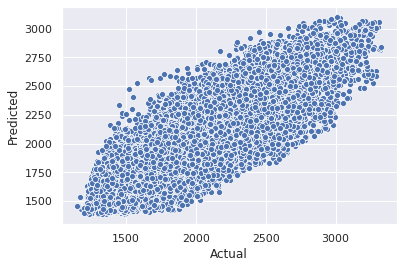

In [ ]:
ax = sns.scatterplot(y_test, pred)
ax.set(xlabel='Actual', ylabel='Predicted')

[Text(0, 0.5, 'Predicted'), Text(0.5, 0, 'Actual')]

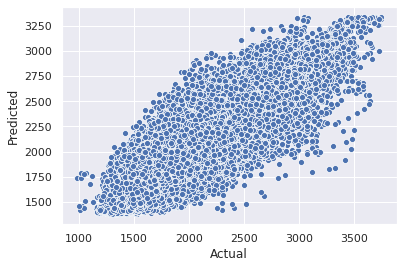

In [ ]:
ax = sns.scatterplot(y_train, model.predict(x_train))
ax.set(xlabel='Actual', ylabel='Predicted')

[Text(0, 0.5, 'Y'), Text(0.5, 0, 'Time')]

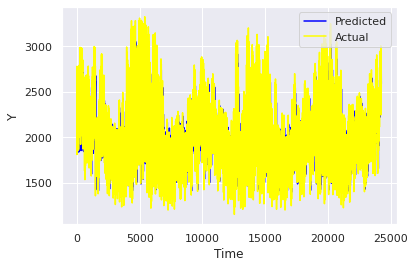

In [ ]:
ax = sns.lineplot(range(x_test.shape[0]), model.predict(x_test), 
                  color="blue", label="Predicted", linestyle="-")
ax = sns.lineplot(range(x_test.shape[0]), y_test, 
                  color="yellow", label="Actual", linestyle="-")

ax.set(xlabel='Time', ylabel='Y')

In [ ]:
lags = []
for c in range(-30, 30):
    lagged = pd.Series(pred).shift(c)
    lags.append(scipy.stats.spearmanr(lagged, y_test, nan_policy='omit')[0])

In [ ]:
### Function definition of code above. Help check autocorrelation between 
## predicted and actual

def get_lag_corr(pred, actual, num_lags):
    lags = []
    for c in range(num_lags):
        lagged = pd.Series(pred).shift(c)
        lags.append(scipy.stats.spearmanr(lagged, actual, nan_policy='omit')[0])
        
    return(lags)

[Text(0, 0.5, 'Corr Coefficient'), Text(0.5, 0, 'Lag')]

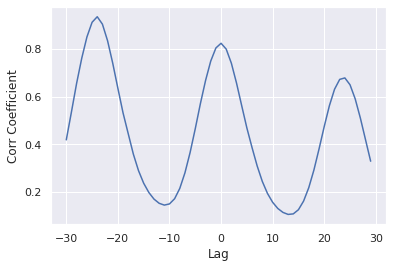

In [ ]:
ax = sns.lineplot(range(-len(lags) // 2, len(lags) // 2), lags, linestyle="-")
ax.set(xlabel='Lag', ylabel='Corr Coefficient')

In [ ]:
### Next Steps

## Implement difference network
## Use with Neural Networks

In [ ]:
### Implement Difference Network
## By subtracting T+0 from T+18
combined_df_difference = combined_df.copy()
combined_df_difference["Diff_y"] = combined_df_difference.iloc[:, -1] - combined_df_difference.iloc[:, -2]

In [ ]:
combined_df_difference.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,Diff_y
24,1596.0,1517.0,1486.0,1469.0,1472.0,1518.0,1598.0,1691.0,1748.0,1825.0,1880.0,1891.0,1874.0,1859.0,1829.0,1807.0,1838.0,1945.0,1968.0,1867.0,1785.0,1711.0,1639.0,1560.0,1723.875000,374.0,388.0,390.0,357.0,289.0,240.0,254.0,220.0,42.0,-95.0,-180.0,-235.0,-299.0,-116.0,1713.0,2167.0,454.0
25,1517.0,1486.0,1469.0,1472.0,1518.0,1598.0,1691.0,1748.0,1825.0,1880.0,1891.0,1874.0,1859.0,1829.0,1807.0,1838.0,1945.0,1968.0,1867.0,1785.0,1711.0,1639.0,1560.0,1713.0,1728.750000,388.0,390.0,357.0,289.0,240.0,254.0,220.0,42.0,-95.0,-180.0,-235.0,-299.0,-116.0,-160.0,1647.0,2110.0,463.0
26,1486.0,1469.0,1472.0,1518.0,1598.0,1691.0,1748.0,1825.0,1880.0,1891.0,1874.0,1859.0,1829.0,1807.0,1838.0,1945.0,1968.0,1867.0,1785.0,1711.0,1639.0,1560.0,1713.0,1647.0,1734.166667,390.0,357.0,289.0,240.0,254.0,220.0,42.0,-95.0,-180.0,-235.0,-299.0,-116.0,-160.0,-227.0,1611.0,2062.0,451.0
27,1469.0,1472.0,1518.0,1598.0,1691.0,1748.0,1825.0,1880.0,1891.0,1874.0,1859.0,1829.0,1807.0,1838.0,1945.0,1968.0,1867.0,1785.0,1711.0,1639.0,1560.0,1713.0,1647.0,1611.0,1739.375000,357.0,289.0,240.0,254.0,220.0,42.0,-95.0,-180.0,-235.0,-299.0,-116.0,-160.0,-227.0,-337.0,1608.0,1980.0,372.0
28,1472.0,1518.0,1598.0,1691.0,1748.0,1825.0,1880.0,1891.0,1874.0,1859.0,1829.0,1807.0,1838.0,1945.0,1968.0,1867.0,1785.0,1711.0,1639.0,1560.0,1713.0,1647.0,1611.0,1608.0,1745.166667,289.0,240.0,254.0,220.0,42.0,-95.0,-180.0,-235.0,-299.0,-116.0,-160.0,-227.0,-337.0,-338.0,1630.0,1861.0,231.0


In [ ]:
combined_df_difference["Diff_y"][:5]

24    454.0
25    463.0
26    451.0
27    372.0
28    231.0
Name: Diff_y, dtype: float64

In [ ]:
train_size = int(combined_df_difference.shape[0] * 0.8)
x_train, y_train = combined_df_difference.iloc[:train_size, :-3], combined_df_difference["Diff_y"][:train_size]
x_test, y_test = combined_df_difference.iloc[train_size:, :-3], combined_df_difference["Diff_y"][train_size:]

In [ ]:
## Collect T+0
tzero_train = combined_df_difference.iloc[:train_size, -3]
tzero_test = combined_df_difference.iloc[train_size:, -3]

In [ ]:
model_diff = xgboost.XGBRegressor(colsample_bytree=0.4,
                 objective="reg:squarederror",
                 max_depth=3,
                 n_estimators=100,                                                                    
                 seed=42) 

In [ ]:
model_diff.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=None, subsample=1, verbosity=1)

In [ ]:
pred = model_diff.predict(x_test)
pred = pred + tzero_test

In [ ]:
mean_squared_error(y_train, model_diff.predict(x_train))

41910.695248561016

In [ ]:
mean_squared_error(y_test + tzero_test, pred)

44573.72277366437

[Text(0, 0.5, 'Predicted'), Text(0.5, 0, 'Actual')]

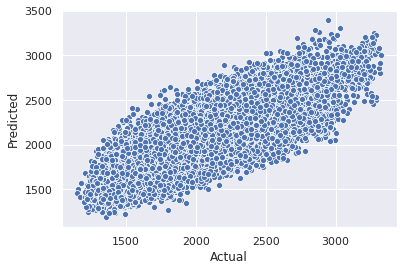

In [ ]:
ax = sns.scatterplot(y_test + tzero_test, pred)
ax.set(xlabel='Actual', ylabel='Predicted')

[Text(0, 0.5, 'Predicted'), Text(0.5, 0, 'Actual')]

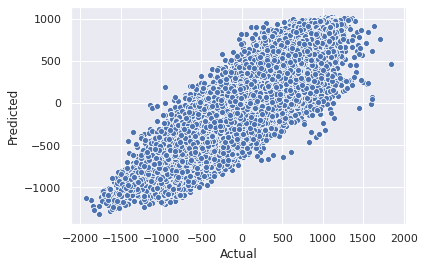

In [ ]:
ax = sns.scatterplot(y_train, model_diff.predict(x_train))
ax.set(xlabel='Actual', ylabel='Predicted')

[Text(0, 0.5, 'Y'), Text(0.5, 0, 'Time')]

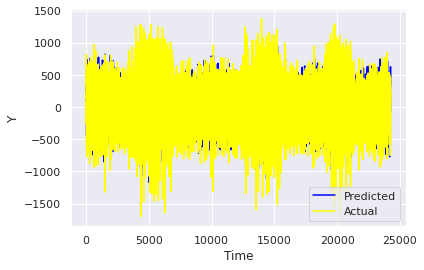

In [ ]:
ax = sns.lineplot(range(x_test.shape[0]), model_diff.predict(x_test), 
                  color="blue", label="Predicted", linestyle="-")
ax = sns.lineplot(range(x_test.shape[0]), y_test, 
                  color="yellow", label="Actual", linestyle="-")

ax.set(xlabel='Time', ylabel='Y')

In [ ]:
### Measures Lag of prediction

In [ ]:
lags = []
for c in range(-30, 30):
    lagged = pd.Series(pred).shift(c)
    lags.append(scipy.stats.spearmanr(lagged, y_test+tzero_test, nan_policy='omit')[0])

[Text(0, 0.5, 'Corr Coefficient'), Text(0.5, 0, 'Lag')]

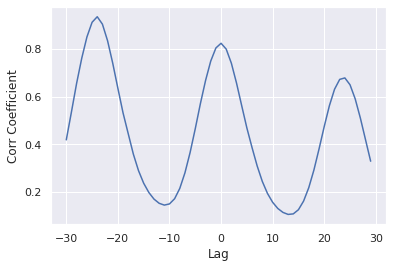

In [ ]:
ax = sns.lineplot(range(-len(lags) // 2, len(lags) // 2), lags, linestyle="-")
ax.set(xlabel='Lag', ylabel='Corr Coefficient')

In [ ]:
## Lag Measure

# z(delta) =  (y(t+delta) * y_hat(t)) / sig(y)*sig(y_hat)
# kendalltau spearmanr pearsonr

In [ ]:
df["DAYTON_MW"]

Datetime
2004-12-31 01:00:00    1596.0
2004-12-31 02:00:00    1517.0
2004-12-31 03:00:00    1486.0
2004-12-31 04:00:00    1469.0
2004-12-31 05:00:00    1472.0
                        ...  
2018-01-01 20:00:00    2732.0
2018-01-01 21:00:00    2724.0
2018-01-01 22:00:00    2664.0
2018-01-01 23:00:00    2614.0
2018-01-02 00:00:00    2552.0
Name: DAYTON_MW, Length: 121275, dtype: float64

In [ ]:
df["DAYTON_MW"].diff(1) ## Lag 24

Datetime
2004-12-31 01:00:00     NaN
2004-12-31 02:00:00   -79.0
2004-12-31 03:00:00   -31.0
2004-12-31 04:00:00   -17.0
2004-12-31 05:00:00     3.0
                       ... 
2018-01-01 20:00:00    18.0
2018-01-01 21:00:00    -8.0
2018-01-01 22:00:00   -60.0
2018-01-01 23:00:00   -50.0
2018-01-02 00:00:00   -62.0
Name: DAYTON_MW, Length: 121275, dtype: float64

In [ ]:
df["DAYTON_MW"].shift(1)

Datetime
2004-12-31 01:00:00       NaN
2004-12-31 02:00:00    1596.0
2004-12-31 03:00:00    1517.0
2004-12-31 04:00:00    1486.0
2004-12-31 05:00:00    1469.0
                        ...  
2018-01-01 20:00:00    2714.0
2018-01-01 21:00:00    2732.0
2018-01-01 22:00:00    2724.0
2018-01-01 23:00:00    2664.0
2018-01-02 00:00:00    2614.0
Name: DAYTON_MW, Length: 121275, dtype: float64

In [ ]:
window_list(df["DAYTON_MW"], 5)

array([[  nan,   nan,   nan,   nan,   nan],
       [  nan,   nan,   nan,   nan, 1596.],
       [  nan,   nan,   nan, 1596., 1517.],
       ...,
       [2441., 2617., 2714., 2732., 2724.],
       [2617., 2714., 2732., 2724., 2664.],
       [2714., 2732., 2724., 2664., 2614.]])

In [ ]:
window_list(df["DAYTON_MW"], 168).shape

(121275, 168)

In [ ]:
cut_final(pd.DataFrame(window_list(df["DAYTON_MW"], 168)))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167
168,1596.0,1517.0,1486.0,1469.0,1472.0,1518.0,1598.0,1691.0,1748.0,1825.0,1880.0,1891.0,1874.0,1859.0,1829.0,1807.0,1838.0,1945.0,1968.0,1867.0,1785.0,1711.0,1639.0,1560.0,1713.0,1647.0,1611.0,1608.0,1630.0,1704.0,1839.0,1986.0,2039.0,2079.0,2113.0,2095.0,2052.0,2014.0,1970.0,1934.0,...,1994.0,2050.0,2078.0,2066.0,2038.0,1996.0,1943.0,1932.0,1995.0,2197.0,2354.0,2358.0,2331.0,2264.0,2181.0,2073.0,2218.0,2154.0,2116.0,2104.0,2108.0,2142.0,2188.0,2267.0,2327.0,2367.0,2367.0,2296.0,2172.0,2090.0,2018.0,1997.0,2019.0,2136.0,2202.0,2184.0,2180.0,2138.0,2069.0,1960.0
169,1517.0,1486.0,1469.0,1472.0,1518.0,1598.0,1691.0,1748.0,1825.0,1880.0,1891.0,1874.0,1859.0,1829.0,1807.0,1838.0,1945.0,1968.0,1867.0,1785.0,1711.0,1639.0,1560.0,1713.0,1647.0,1611.0,1608.0,1630.0,1704.0,1839.0,1986.0,2039.0,2079.0,2113.0,2095.0,2052.0,2014.0,1970.0,1934.0,1947.0,...,2050.0,2078.0,2066.0,2038.0,1996.0,1943.0,1932.0,1995.0,2197.0,2354.0,2358.0,2331.0,2264.0,2181.0,2073.0,2218.0,2154.0,2116.0,2104.0,2108.0,2142.0,2188.0,2267.0,2327.0,2367.0,2367.0,2296.0,2172.0,2090.0,2018.0,1997.0,2019.0,2136.0,2202.0,2184.0,2180.0,2138.0,2069.0,1960.0,2035.0
170,1486.0,1469.0,1472.0,1518.0,1598.0,1691.0,1748.0,1825.0,1880.0,1891.0,1874.0,1859.0,1829.0,1807.0,1838.0,1945.0,1968.0,1867.0,1785.0,1711.0,1639.0,1560.0,1713.0,1647.0,1611.0,1608.0,1630.0,1704.0,1839.0,1986.0,2039.0,2079.0,2113.0,2095.0,2052.0,2014.0,1970.0,1934.0,1947.0,2095.0,...,2078.0,2066.0,2038.0,1996.0,1943.0,1932.0,1995.0,2197.0,2354.0,2358.0,2331.0,2264.0,2181.0,2073.0,2218.0,2154.0,2116.0,2104.0,2108.0,2142.0,2188.0,2267.0,2327.0,2367.0,2367.0,2296.0,2172.0,2090.0,2018.0,1997.0,2019.0,2136.0,2202.0,2184.0,2180.0,2138.0,2069.0,1960.0,2035.0,1968.0
171,1469.0,1472.0,1518.0,1598.0,1691.0,1748.0,1825.0,1880.0,1891.0,1874.0,1859.0,1829.0,1807.0,1838.0,1945.0,1968.0,1867.0,1785.0,1711.0,1639.0,1560.0,1713.0,1647.0,1611.0,1608.0,1630.0,1704.0,1839.0,1986.0,2039.0,2079.0,2113.0,2095.0,2052.0,2014.0,1970.0,1934.0,1947.0,2095.0,2167.0,...,2066.0,2038.0,1996.0,1943.0,1932.0,1995.0,2197.0,2354.0,2358.0,2331.0,2264.0,2181.0,2073.0,2218.0,2154.0,2116.0,2104.0,2108.0,2142.0,2188.0,2267.0,2327.0,2367.0,2367.0,2296.0,2172.0,2090.0,2018.0,1997.0,2019.0,2136.0,2202.0,2184.0,2180.0,2138.0,2069.0,1960.0,2035.0,1968.0,1950.0
172,1472.0,1518.0,1598.0,1691.0,1748.0,1825.0,1880.0,1891.0,1874.0,1859.0,1829.0,1807.0,1838.0,1945.0,1968.0,1867.0,1785.0,1711.0,1639.0,1560.0,1713.0,1647.0,1611.0,1608.0,1630.0,1704.0,1839.0,1986.0,2039.0,2079.0,2113.0,2095.0,2052.0,2014.0,1970.0,1934.0,1947.0,2095.0,2167.0,2110.0,...,2038.0,1996.0,1943.0,1932.0,1995.0,2197.0,2354.0,2358.0,2331.0,2264.0,2181.0,2073.0,2218.0,2154.0,2116.0,2104.0,2108.0,2142.0,2188.0,2267.0,2327.0,2367.0,2367.0,2296.0,2172.0,2090.0,2018.0,1997.0,2019.0,2136.0,2202.0,2184.0,2180.0,2138.0,2069.0,1960.0,2035.0,1968.0,1950.0,1954.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121269,2547.0,2494.0,2428.0,2334.0,2225.0,2105.0,2396.0,2362.0,2343.0,2350.0,2319.0,2344.0,2388.0,2448.0,2482.0,2506.0,2492.0,2446.0,2415.0,2360.0,2308.0,2300.0,2310.0,2432.0,2488.0,2441.0,2392.0,2308.0,2207.0,2113.0,2513.0,2486.0,2479.0,2476.0,2488.0,2558.0,2621.0,2692.0,2747.0,2768.0,...,2503.0,2526.0,2581.0,2702.0,2868.0,2980.0,3007.0,2999.0,3000.0,2962.0,2914.0,2854.0,2788.0,2733.0,2742.0,2880.0,2971.0,2971.0,2932.0,2865.0,2771.0,2674.0,2306.0,2286.0,2266.0,2256.0,2248.0,2288.0,2337.0,2400.0,2427.0,2452.0,2481.0,2480.0,2454.0,2419.0,2372.0,2384.0,

In [ ]:
## MAE RMSE MSE etc
